# Training a random medium by a complex medium to generate a target coherent state
## Phase space approach

Use the multi-heads (2-head) gates in the phase space 
to create a network that represent a coherent state 
propagating in a random medium. 
Use a trainable complex medium to obtain a target state


<img src="./logo_circular.png" width="20" height="20" />@by claudio<br>

nonlinearxwaves@gmail.com<br>
@created 22 july 2020<br>
@version 10 april 2022

In [1]:
#import sys
#sys.path.append('../../')

In [2]:
import numpy as np
#from quomplex2021 import phasespace as ps
#from quomplex2021.utilities import utilities
import tensorflow as tf
#import tensorflow_addons as tfa
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow import keras
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping

2022-04-12 05:53:45.316116: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-04-12 05:53:45.316181: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [3]:
tf_complex = tf.complex
tf_real = tf.float32
np_complex = complex
np_real = np.float64

Set the precision for the output

In [4]:
np.set_printoptions(precision=4)

## Dimension

In [5]:
N = 20

# Define useful functions

In [6]:
tf_real = tf.float32
np_real = np.float32
tf_complex = tf.complex
np_complex = complex
default_N = 10

def RQRP(N=default_N, dtype=np_real, **kwargs):
    """

     Parameters
     ----------
     N : TYPE, dimension of R (2 times the number of bodies n)
         DESCRIPTION. The default is 10.

    Default type for the output matrices is np_real

     Returns
     -------
     The projection matricex RX and RP, and the matrix J

    """
    assert N % 2 == 0, " Dimension N must be even "
    n = np.floor_divide(N, 2)
    RQ = np.zeros((N, n), dtype=dtype)
    RP = np.zeros((N, n), dtype=dtype)
    c = -1
    d = -1
    for j in range(N):
        if j % 2 == 0:
            c = c + 1
            RQ[j, c] = 1.0
        else:
            d = d + 1
            RP[j, d] = 1.0
    J = np.matmul(RQ, RP.transpose()) - np.matmul(RP, RQ.transpose())
    return RQ, RP, J



class VacuumLayer(layers.Layer):
    """
        Define a Gaussian state as a neural network layer
    """

    def __init__(self, N=10, dtype=tf_real,**kwargs):
        super(VacuumLayer, self).__init__(**kwargs)
        g_in=np.eye(N, dtype=np_real)
        d_in=np.zeros((N, 1))
        self.N = N
        assert self.N % 2 == 0, \
            " Dimension must be even "
        self.g_np = g_in
        self.d_np = d_in
        self.g = tf.Variable(self.g_np, dtype=self.dtype,
                             trainable=False)
        self.d = tf.Variable(self.d_np, dtype=self.dtype,
                             trainable=False)
        self.DotLayer = tf.keras.layers.Dot(axes=1)


    def call(self, x, di=None): 
        # [chir, chii] = self.call(x,a)
        # [chir, chii] = self.call(x) , here a=0 as default
        # param: x the input row vector (Nbatch, N)
        # param: a the input ancillas column vector (N,1)
        # output: chir, the real part of the characteristic function
        # output: chii, the imaginary part of the characteritic function
        if di is None:
            di1 = tf.constant(np.zeros((self.n, 1)), dtype=tf_real)
        else:
            di1 = di
        yi = tf.matmul(x, self.d+di1)
        yR = tf.matmul(x, self.g, transpose_b=True) # note the transpose here, needed for DotLayer
        gDot = self.DotLayer([x, yR])
        yr2 = tf.multiply(-0.25, gDot)
        return [tf.multiply(tf.exp(yr2),tf.cos(yi)), tf.multiply(tf.exp(yr2),tf.sin(yi))]

    
class LinearLayerConstant(layers.Layer):
    """
    Define a multi-headed linear layer corresponding to the
    \tilde a = U a
    with U a unitary complex matrix
    In the R space, corresponds to
    \tilde R = M R +d1

    In input has input N, the size of the R vector (must be even)
    RETURN y and MI inverse of M

    Examples
    --------
    L=LinearLayerConstant(np.eye(10),np.zeros(10,1),tf.double) # create class
    y, b = L(x) # zero ancillas
    y, b = L(x,a)

    Remark
    ------
    DOES NOT CHECK IF M IS SYMPLECTIC
    Dimension N is extracted from M, d1 dimension is checked for consistency

    TODO
    ----
    TODO, add control on the input M if symplectic
    """

    def __init__(self, M_np, d1_np, **kwargs):
        """ init the linear layer

        Parameters
        ----------
        M_np : NxN symplectic matrix
        d1_np : Nx1 displacement vector


        Returns
        -------
        L : an object of the class LinearLayerConstant


        """
        super(LinearLayerConstant, self).__init__(**kwargs)
        N, Nc = M_np.shape
        Ndc, Ndr = d1_np.shape
        # check parameter size
        assert N % 2 == 0, " Dimension must be even "
        assert N == Nc, " M matrix must be squared "
        assert Ndc == N, " d1 must have dimensions Nx1 "
        assert Ndr == 1, " d1 must have dimensions Nx1 "
        self.N = N
        # Create the symplectic matrix
        _, _, J = RQRP(N)
        # Compute the inverse matrix
        MI_np = np.matmul(J.transpose(), np.matmul(M_np.transpose(), J))

        # store M and d as constant tensors
        self.M = tf.constant(M_np, dtype=self.dtype, name="M")
        self.d1 = tf.constant(d1_np, dtype=self.dtype, name="d")

        # inverse of M as constant tensors
        self.MI = tf.constant(MI_np, dtype=self.dtype)

    def call(self, x, a=None):
        """ call the linear layer

        Parameters
        ----------
        x: input vector 1xN
        a: ancillas vectors Nx1 (if None is zero)

        Returns
        -------
        y = x M
        b = M^(-1) d1

        """
        y = tf.matmul(x, self.M)
        if a is None:
            b = tf.matmul(self.MI, self.d1)
        else:
            b = tf.matmul(self.MI, self.d1+a)
        return [y, b]


def DisplacementLayerConstant(dtarget_np, **kwargs):
    """Return a constant displacemente layer

    Return LinearLayerConstant non-trainable with identity matrix
    and given input displacement

    Parameters
    ---------
    dtarget: displacement vector with shape (N,1)

    Returns
    -------
    output: LinearConstant M=np.eye(N) and d=dtarget
    """
    N = dtarget_np.shape[0]  # extract N from input
    assert dtarget_np.shape[-1] == 1, " Dtarget must be a column vector"
    L = LinearLayerConstant(np.eye(N), dtarget_np, **kwargs)
    return L

class RandomLayer(layers.Layer):
    """  Define a linear random layer corresponding to the
    a = U a
    with U a unitary complex matrix
    In the R space, corresponds to
    x = R x
    In input has input N, the size of the R vector (must be even)

    Parameters in the constructor
    ----------------------------
    :param N: dimension
    :param trainable_M: if false M is not trained, default is true
    :param M_np: covariance matrix of the Gaussian layer
    :param d_np: displacement vector of the Gaussian layer
    (None is default for a zero non trainable d)
    :param trainable_d: if False the Gaussian covariance matrix and displacement are not trainable (defaul is true)

    :output x M
    :output b = M^(-1) d

    """

    def __init__(self, N=10, trainable_M=True, d_np=None,
                 trainable_d=True, **kwargs):
        super(RandomLayer, self).__init__(**kwargs)
        assert N % 2 == 0, " Dimension must be even "
        self.trainable_d = trainable_d
        self.trainable_M = trainable_M
        self.N = N
        n = np.floor_divide(self.N, 2)
        wr_np = np.random.random((n, n))
        wi_np = np.random.random((n, n))
        # define the name as scope (useful for plotting the model)
        with tf.name_scope(self.name) as scope:
            self.WR = tf.Variable(
                wr_np, dtype=self.dtype, trainable=self.trainable_M, name="WR"
            )
            self.WI = tf.Variable(
                wi_np, dtype=self.dtype, trainable=self.trainable_M, name="WI"
            )
        Rx, Rp, J = RQRP(N)
        self.Rx = tf.constant(Rx, dtype=self.dtype)
        self.Rp = tf.constant(Rp, dtype=self.dtype)
        self.J = tf.constant(J, dtype=self.dtype)
        if d_np is None:
            # the layer has a constant zero displacement
            self.d = tf.constant(
                np.zeros((N, 1), dtype=np_real), dtype=self.dtype)
            trainable_d = False
        else:
            # the layer has a trainable displacement
            # if trainable_d is set to true (default is false)
            self.d = tf.Variable(d_np, dtype=self.dtype, trainable=trainable_d)

    def get_M(self):
        """ return the M matrix and its inverse MI """
        # generate symmetric matrix
        HR = self.WR + tf.transpose(self.WR)
        # generate an antisymmetric matrix
        HI = self.WI - tf.transpose(self.WI)
        # exponentiate the Hermitian matrix time the imaginary unit
        U = tf.linalg.expm(tf.complex(-HI, HR))
        # return the real and immaginary part
        UR = tf.math.real(U)
        UI = tf.math.imag(U)
        # Build the symplectic matrix M
        M = (
            tf.matmul(self.Rx, tf.matmul(UR, self.Rx, transpose_b=True))
            + tf.matmul(self.Rp, tf.matmul(UR, self.Rp, transpose_b=True))
            - tf.matmul(self.Rx, tf.matmul(UI, self.Rp, transpose_b=True))
            + tf.matmul(self.Rp, tf.matmul(UI, self.Rx, transpose_b=True))
        )
        # Inverse of M
        MI = tf.matmul(tf.matmul(M, self.J), self.J, transpose_a=True)
        return M, MI

    def call(self, x, di=None):
        # generate symmetric matrix
        HR = self.WR + tf.transpose(self.WR)
        # generate an antisymmetric matrix
        HI = self.WI - tf.transpose(self.WI)
       # exponentiate the Hermitian matrix time the imaginary unit
        U = tf.linalg.expm(tf.complex(-HI, HR))
        # return the real and immaginary part
        UR = tf.math.real(U)
        UI = tf.math.imag(U)
        # Build the symplectic matrix M
        M = (
            tf.matmul(self.Rx, tf.matmul(UR, self.Rx, transpose_b=True))
            + tf.matmul(self.Rp, tf.matmul(UR, self.Rp, transpose_b=True))
            - tf.matmul(self.Rx, tf.matmul(UI, self.Rp, transpose_b=True))
            + tf.matmul(self.Rp, tf.matmul(UI, self.Rx, transpose_b=True))
        )
        # Inverse of M
        MI = tf.matmul(tf.matmul(M, self.J), self.J, transpose_a=True)
        # no transpose here for M, as M is already transpose
        if di is None:
            d2 = tf.constant(
                np.zeros((self.N, 1), dtype=np_real), dtype=self.dtype)
        else:
            d2 = di
        # return tensor list(check this ... and test x,y =R o x=R w/o questo
        return [tf.matmul(x, M), tf.matmul(MI, d2 + self.d)]

    
def RandomLayerConstant(N=default_N, **kwargs):
    """Return a class ResidualGaussianMultihead non-trainable
    with a random unitary (a constant RandomLayer)

    Parameters
    ----------
    N: size of the vector

    Returns
    -------
    a Constant RandomLayer
    """

    return RandomLayer(N,
                       trainable_M=False,
                       trainable_d=False,
                       trainable=False,
                       **kwargs)


## Build vacuum by the Gaussian state

In [7]:
vacuum = VacuumLayer(N, name = 'Vacuum')

2022-04-12 05:53:47.681792: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-04-12 05:53:47.681823: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-04-12 05:53:47.681849: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (x1): /proc/driver/nvidia/version does not exist
2022-04-12 05:53:47.682610: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Build the pullback layer for generating the input coherent state

### Target displacement vector (IMPORTANT THE DISPLACEMENT VECTOR MUST BE NORMALIZED!!!)
The displacement vector is a normalized column vector

In [8]:
dinput = 3.0*np.ones((N,1)); 

Normalize the dinput (this is needed as we want to training with constant photon number, the target displacement and the input must have the same norm)

In [9]:
norm = np.linalg.norm(dinput)
dinput = dinput /norm
print(dinput.transpose())
print(np.dot(dinput.transpose(), dinput))

[[0.2236 0.2236 0.2236 0.2236 0.2236 0.2236 0.2236 0.2236 0.2236 0.2236
  0.2236 0.2236 0.2236 0.2236 0.2236 0.2236 0.2236 0.2236 0.2236 0.2236]]
[[1.]]


## Define the linear Glauber layer
The layer is a constant layer, as no training is needed

In [10]:
D = DisplacementLayerConstant(dinput, name = 'GlauberLayer')

## Define the layer for the untrainable complex medium
We can give a name to the layer to appear in the model summary

In [11]:
R = RandomLayerConstant(N, name = 'RandomLayerConstant')

## Define the trainable random layer

In [12]:
T = RandomLayer(N, name='RandomLayer')

## Define the normalize target displacement vector <br>
The target displacement vector must have the same norm of the input as the photon number is conserved

In [13]:
dtarget = np.zeros((N,1)); dtarget[0]=3.14; dtarget[1]=1.0; 
norm = np.linalg.norm(dtarget)
dtarget = dtarget /norm
print(dtarget.transpose())

[[0.9528 0.3035 0.     0.     0.     0.     0.     0.     0.     0.
  0.     0.     0.     0.     0.     0.     0.     0.     0.     0.    ]]


## Connect the layers (in reverse order)

In [14]:
xin = tf.keras.layers.Input(N)
x3, a3 = R(xin)
x2, a2 = T(x3, a3)
x1, a1 = D(x2,a2)
chir, chii = vacuum(x1, a1)

In [15]:
model = tf.keras.Model(inputs = xin, outputs=[chir, chii])

## Test the model by derivatives

In [16]:
xzero = tf.constant(np.zeros((1,N)))
with tf.GradientTape(persistent=True) as tape:
    tape.watch(xzero)
    chir, chii = model(xzero)         

In [17]:
tf.print(tape.gradient(chir,xzero))

[[0 0 0 ... 0 0 0]]


In [18]:
tf.print(tape.gradient(chii,xzero))

[[-0.11894206702709198 0.36522388458251953 -0.13525484502315521 ... 0.33179816603660583 -0.022210841998457909 0.11927178502082825]]


## Build the training set by using a target characteristic function

Number of training points

In [19]:
Nbatch = 100

Define the numpy function for the target characteristic function:
    a coherent state with a target displacement

In [20]:
def chi_target(x, d):
    """ Characteristic function of a Gaussian coherent state
    Parameters
    ----------
    :param x: input
    :param d: displacement vector
    """
    yr = -0.25*np.matmul(x, x.transpose())
    yi = np.matmul(x, d)
    #return yr, yi
    return np.exp(yr)*np.cos(yi), np.exp(yr)*np.sin(yi)

Generate the training set

In [21]:
xtrain = np.random.rand(Nbatch, N)-0.5
chitestr = np.zeros(Nbatch)
chitesti = np.zeros(Nbatch)
for j in range(Nbatch):
    chitestr[j], chitesti[j] = chi_target(xtrain[j], dtarget)

## Train the model

In [22]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
                loss='mean_squared_error')

In [23]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 20)]         0           []                               
                                                                                                  
 RandomLayerConstant (RandomLay  [(None, 20),        200         ['input_1[0][0]']                
 er)                             (20, 1)]                                                         
                                                                                                  
 RandomLayer (RandomLayer)      [(None, 20),         200         ['RandomLayerConstant[0][0]',    
                                 (20, 1)]                         'RandomLayerConstant[0][1]']    
                                                                                              

## Model graph

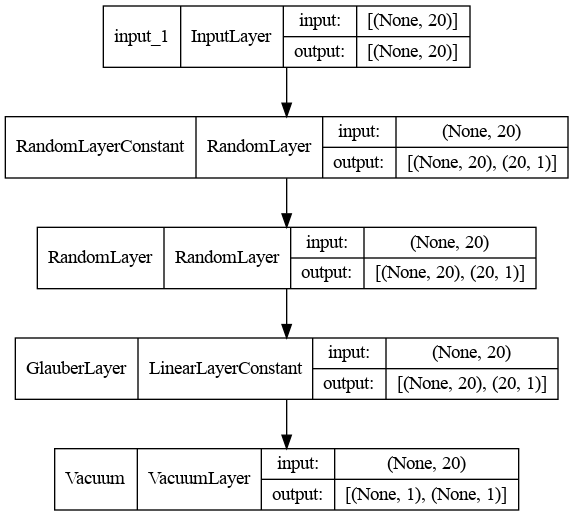

In [24]:
tf.keras.utils.plot_model(model, to_file='./modelGaussian.png', show_shapes=True)

## Training

Note the model as 200 trainable weight, corresponding to random layer 1, which is the only trainable

In [25]:
history=model.fit(x=xtrain, y=(chitestr, chitesti), epochs=100, verbose=1)

Epoch 1/100
4/4 [==============================] - 1s 2ms/step - loss: 0.0512 - Vacuum_loss: 0.0012 - Vacuum_1_loss: 0.0500
Epoch 2/100
4/4 [==============================] - 0s 2ms/step - loss: 0.0382 - Vacuum_loss: 0.0010 - Vacuum_1_loss: 0.0372
Epoch 3/100
4/4 [==============================] - 0s 2ms/step - loss: 0.0332 - Vacuum_loss: 0.0010 - Vacuum_1_loss: 0.0321
Epoch 4/100
4/4 [==============================] - 0s 2ms/step - loss: 0.0304 - Vacuum_loss: 0.0010 - Vacuum_1_loss: 0.0294
Epoch 5/100
4/4 [==============================] - 0s 2ms/step - loss: 0.0274 - Vacuum_loss: 0.0010 - Vacuum_1_loss: 0.0264
Epoch 6/100
4/4 [==============================] - 0s 2ms/step - loss: 0.0247 - Vacuum_loss: 9.8330e-04 - Vacuum_1_loss: 0.0238
Epoch 7/100
4/4 [==============================] - 0s 2ms/step - loss: 0.0213 - Vacuum_loss: 8.8843e-04 - Vacuum_1_loss: 0.0205
Epoch 8/100
4/4 [==============================] - 0s 2ms/step - loss: 0.0194 - Vacuum_loss: 8.2281e-04 - Vacuum_1_loss: 0.0

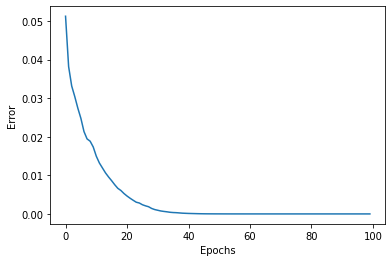

In [26]:
# %%
# %matplotlib inline
# Plot training & validation accuracy values
f1 = plt.figure
#plt.subplot(2, 1s'])
plt.plot(history.history['loss'])
plt.ylabel('Error')
plt.xlabel('Epochs')
plt.savefig('training1.pdf')

## Test the derivative of the model
Evaluate the expectation value of the displacement as derivative of the characterisc function

In [27]:
#x = tf.constant(np.zeros((1,N)), dtype=tf_real) # the derivative are evaluated at x=0
with tf.GradientTape(persistent=True) as tape:
    tape.watch(xzero)
    chir, chii = model(xzero)

In [28]:
print(tape.gradient(chir,xzero))

tf.Tensor([[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]], shape=(1, 20), dtype=float64)


## Compare the derivative of the chi and the target vector

In [29]:
tf.print(tape.gradient(chii,xzero))

[[0.95284616947174072 0.30345401167869568 1.0430812835693359e-07 ... 9.1642141342163086e-07 -4.3213367462158203e-07 2.0861625671386719e-07]]


In [30]:
print(dtarget.transpose())

[[0.9528 0.3035 0.     0.     0.     0.     0.     0.     0.     0.
  0.     0.     0.     0.     0.     0.     0.     0.     0.     0.    ]]
